In [1]:
##### Change to main folder of project, run only once!
import os
os.chdir('../')

In [2]:
from hyperopt import tpe, hp, fmin, STATUS_OK, Trials, rand
import logging
import numpy as np

from top2vec import Top2Vec
from sentence_transformers import SentenceTransformer
import os
import sys
import logging

logging.basicConfig(stream=sys.stdout,
                    level=logging.INFO,
                    format='%(asctime)s | [%(filename)s:%(lineno)d] %(levelname)s | %(message)s')
logger = logging.getLogger(__name__)

#dataset_name = "./models/top2vec/labse-fr-dataset"
model_path = "./models/top2vec/labse-three-year"

pretrained_model = SentenceTransformer('sentence-transformers/LaBSE', device="cpu")  
top2vec_model = Top2Vec.load(os.path.normpath(model_path))
top2vec_model.set_embedding_model(pretrained_model)
print("topics of loaded model", top2vec_model.get_num_topics())
loaded_embeddings = top2vec_model.document_vectors


def hyperparameter_tuning(params, model=top2vec_model, target_clusters=50):
    umap_args = {
        "n_neighbors": params["n_neighbors"],
        "n_components": params["n_components"],
        "metric": params["umap_metric"]
    }
    hdbscan_args = {
        'min_cluster_size': params["min_cluster_size"],
        'metric': params["hdbscan_metric"],
        'cluster_selection_method': params["cluster_selection_method"]
    }
    
    model.compute_topics(
        umap_args=umap_args,
        gpu_umap=True,
        hdbscan_args=hdbscan_args,
        gpu_hdbscan=False,
        topic_merge_delta=params["topic_merge_delta"]
    )
    
    n_clusters = model.get_num_topics()

    logging.debug(f"Found {n_clusters} labels")
    loss = np.abs(target_clusters - n_clusters)


    return {"status": STATUS_OK, "loss": loss, "n_clusters": n_clusters}

2024-11-13 10:33:28,629 | [SentenceTransformer.py:216] INFO | Load pretrained SentenceTransformer: sentence-transformers/LaBSE
topics of loaded model 11


In [ ]:
# Initialize trials object
trials = Trials()

In [ ]:
n_neighbors = [5, 10, 15, 20, 25, 40, 45, 55]
n_components = [3, 5, 7, 9, 13, 17, 20, 23]
umap_metric = ["euclidean", "cosine"]
min_cluster_size = [5, 10, 15, 20, 25]
hdbscan_metric = ["euclidean"]
cluster_selection_method = ["eom", "leaf"]
topic_merge_delta = [0.05, 0.1, 0.15]

space = {
    "n_neighbors": hp.choice("n_neighbors", n_neighbors),
    "n_components": hp.choice("n_components", n_components),
    "umap_metric": hp.choice("umap_metric", umap_metric),
    "min_cluster_size": hp.choice("min_cluster_size", min_cluster_size),
    "hdbscan_metric": hp.choice("hdbscan_metric", hdbscan_metric), 
    "cluster_selection_method": hp.choice("cluster_selection_method", cluster_selection_method),
    "topic_merge_delta": hp.choice("topic_merge_delta", topic_merge_delta),

}


best = fmin(
    fn=hyperparameter_tuning,
    space = space, 
    algo=tpe.suggest, #tpe.rand.suggest
    max_evals=600, #200, 
    trials=trials,
    trials_save_file="./trials-save-file.trials"
)

print("Best: {}".format(best))

In [ ]:
import pickle
with open("trials-save-file.trials", "rb") as f:
    t_loaded = pickle.load(f)

t_loaded.best_trial

In [ ]:
import pandas as pd
from pathlib import Path
import json

def unpack(x):
    if x:
        return x[0]
    return np.nan

trials_df = pd.DataFrame([pd.Series(t["misc"]["vals"]).apply(unpack) for t in t_loaded])
trials_df["loss"] = [t["result"].get("loss", 9999) for t in t_loaded]

trials_df["n_neighbors"] = trials_df["n_neighbors"].replace(list(range(len(n_neighbors))), n_neighbors)
trials_df["n_components"] = trials_df["n_components"].replace(list(range(len(n_components))), n_components)
trials_df["umap_metric"] = trials_df["umap_metric"].replace(list(range(len(umap_metric))), umap_metric)
trials_df["min_cluster_size"] = trials_df["min_cluster_size"].replace(list(range(len(min_cluster_size))), min_cluster_size)
trials_df["hdbscan_metric"] = trials_df["hdbscan_metric"].replace(list(range(len(hdbscan_metric))), hdbscan_metric)
trials_df["cluster_selection_method"] = trials_df["cluster_selection_method"].replace(list(range(len(cluster_selection_method))), cluster_selection_method)
trials_df["topic_merge_delta"] = trials_df["topic_merge_delta"].replace(list(range(len(topic_merge_delta))), topic_merge_delta)

trials_df.sort_values(by="loss", inplace=True)


experiment_params = {
    "n_neighbors": n_neighbors,
    "n_components": n_components,
    "umap_metric": umap_metric,
    "min_cluster_size": min_cluster_size,
    "hdbscan_metric": hdbscan_metric,
    "cluster_selection_method": cluster_selection_method,
    "topic_merge_delta": topic_merge_delta,
}

experiment_start = [t for t in t_loaded][0]["book_time"]
experiment_end = [t for t in t_loaded][-1]["book_time"]
timestamp_start = experiment_start.strftime('%Y-%m-%d-%H-%M-%S')
timestamp_end = experiment_start.strftime('%Y-%m-%d-%H-%M-%S')
experiment_folder = os.path.normpath(f"./analysis/umap-hdbet-hyperopt-{timestamp_start}-{timestamp_end}/")
Path(experiment_folder).mkdir(parents=True, exist_ok=True)

with open(os.path.join(experiment_folder, "model-path.txt"), "w") as f:
    f.write(model_path)

with open(os.path.join(experiment_folder, "optimization-space.json"), "w") as f:
    json.dump(experiment_params, f)

trials_df.to_csv(os.path.join(experiment_folder, "optimization-results.csv"))

with open(os.path.join(experiment_folder, "trials.pickle"), 'wb') as handle:
    pickle.dump(trials, handle)


trials_df.head()

,cluster_selection_method,hdbscan_metric,min_cluster_size,n_components,n_neighbors,topic_merge_delta,umap_metric,loss
568,eom,euclidean,20,5,40,0.05,euclidean,5.0
577,eom,euclidean,20,5,40,0.05,euclidean,7.0
576,eom,euclidean,20,5,40,0.05,euclidean,7.0
555,eom,euclidean,20,5,40,0.10,euclidean,8.0
563,eom,euclidean,20,5,40,0.10,euclidean,8.0


In [ ]:
# Reload from disk
import pandas as pd
import os


df = pd.read_csv(os.path.normpath("./analysis/umap-hdbet-hyperopt-2024-11-11-20-40-46-2024-11-11-20-40-46/optimization-results.csv"), index_col=0)
# remove outliers/nan loss
df = df[df["loss"] != 9999]
df.head()

,cluster_selection_method,hdbscan_metric,min_cluster_size,n_components,n_neighbors,topic_merge_delta,umap_metric,loss
568,eom,euclidean,20,5,40,0.05,euclidean,5.0
577,eom,euclidean,20,5,40,0.05,euclidean,7.0
576,eom,euclidean,20,5,40,0.05,euclidean,7.0
555,eom,euclidean,20,5,40,0.10,euclidean,8.0
563,eom,euclidean,20,5,40,0.10,euclidean,8.0


In [3]:
df_loss_filter = df.loss < 50

In [4]:
df[df_loss_filter].head()

,cluster_selection_method,hdbscan_metric,min_cluster_size,n_components,n_neighbors,topic_merge_delta,umap_metric,loss
568,eom,euclidean,20,5,40,0.05,euclidean,5.0
577,eom,euclidean,20,5,40,0.05,euclidean,7.0
576,eom,euclidean,20,5,40,0.05,euclidean,7.0
555,eom,euclidean,20,5,40,0.10,euclidean,8.0
563,eom,euclidean,20,5,40,0.10,euclidean,8.0


In [5]:
import matplotlib.pyplot as plt
from pathlib import Path

def variable_plot(variable, df=df, df_loss_filter = df.loss < 50):
    print(f"Visualizing the variable: {variable} vs loss.")
    print(df[df_loss_filter][[variable]].value_counts())
    df[df_loss_filter][[variable, "loss"]].boxplot(by=variable, figsize=(7,2))
    plt.title(f"loss grouped by {variable}")
    plt.suptitle('')
    Path("./analysis/graphics/").mkdir(parents=True, exist_ok=True)
    plt.savefig(f"./analysis/graphics/{variable}.pdf")

def get_quantiles(variable:str, keys:list):
    print(df[df_loss_filter][[variable, "loss"]].groupby(variable).quantile([0.25, 0.5, 0.75]).loc[keys])

print(f"Number of samples in this selection: {len(df[df_loss_filter])}")
variables = [
    "n_neighbors",
    "n_components",
    "umap_metric",
    "min_cluster_size",
    "hdbscan_metric",
    "cluster_selection_method",
    "topic_merge_delta",
]


Number of samples in this selection: 188


Visualizing the variable: n_neighbors vs loss.
n_neighbors
45             132
40              31
55              20
25               5
Name: count, dtype: int64
                  loss
n_neighbors           
40          0.25  11.5
            0.50  28.0
            0.75  39.0
45          0.25  22.0
            0.50  38.0
            0.75  39.0


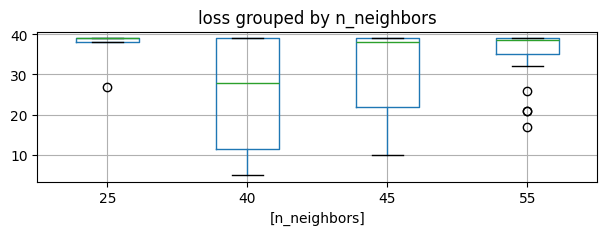

In [6]:
variable_plot(variables[0])
get_quantiles(variables[0], [40, 45])

Visualizing the variable: n_components vs loss.
n_components
9               62
5               40
13              25
20              20
17              12
7               11
23              11
3                7
Name: count, dtype: int64
                    loss
n_components            
3            0.25  32.00
             0.50  38.00
             0.75  38.50
5            0.25  12.25
             0.50  17.50
             0.75  28.25
9            0.25  33.75
             0.50  39.00
             0.75  39.00


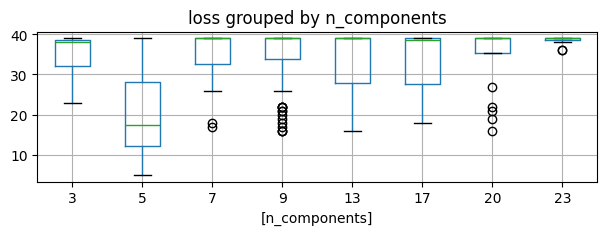

In [7]:
variable_plot(variables[1])
get_quantiles(variables[1], [3, 5, 9])

Visualizing the variable: umap_metric vs loss.
umap_metric
cosine         108
euclidean       80
Name: count, dtype: int64


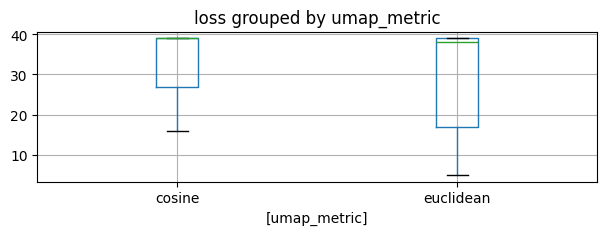

In [8]:
variable_plot(variables[2])

Visualizing the variable: min_cluster_size vs loss.
min_cluster_size
25                  141
20                   44
15                    2
5                     1
Name: count, dtype: int64
                       loss
min_cluster_size           
20               0.25  13.0
                 0.50  36.0
                 0.75  39.0
25               0.25  24.0
                 0.50  39.0
                 0.75  39.0


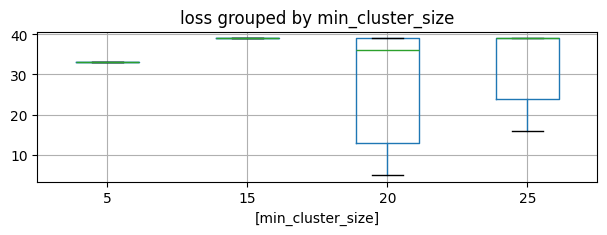

In [9]:
variable_plot(variables[3])
get_quantiles(variables[3], [20, 25])

Visualizing the variable: cluster_selection_method vs loss.
cluster_selection_method
eom                         188
Name: count, dtype: int64


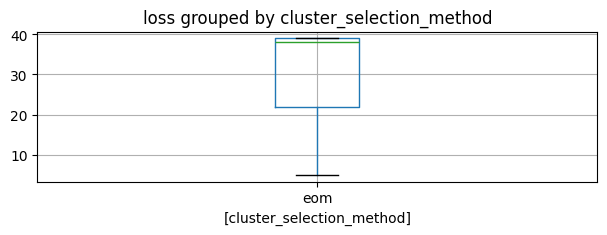

In [10]:
variable_plot(variables[5])

Visualizing the variable: topic_merge_delta vs loss.
topic_merge_delta
0.10                 149
0.05                  21
0.15                  18
Name: count, dtype: int64
                         loss
topic_merge_delta            
0.05              0.25  15.00
                  0.50  38.00
                  0.75  39.00
0.10              0.25  21.00
                  0.50  38.00
                  0.75  39.00
0.15              0.25  26.25
                  0.50  39.00
                  0.75  39.00


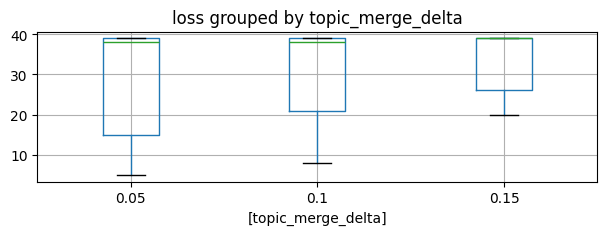

In [11]:
variable_plot(variables[6])
get_quantiles(variables[6], [0.05, 0.1, 0.15])

In [12]:
df.head(1)

,cluster_selection_method,hdbscan_metric,min_cluster_size,n_components,n_neighbors,topic_merge_delta,umap_metric,loss
568,eom,euclidean,20,5,40,0.05,euclidean,5.0


# Conclusion
For totaly 578 experiments we are investigating the subset of parameters that have a loss of lower than 50. This are 188 experiments in total.

n_neighbors:  
n_neighbors 40 has the lowest median loss with 28 but is still within the 25% quantile of 22 of the 45 n_neighbors group. We can not for sure conclude the optimal parameter but we should tend towards 40.

n_components:  
For 5 components we clearly see that the median with 17.5 loss is outside of every other variables 25% quantile for the filtered experiments. We conclude that we shall choose 5 components.

umap_metric:  
No significant difference can be shown between cosine and euclidean. The euclidean metric shows a bigger variance

min_cluste_size:  
For the 188 filtered trials 5 and 15 only represent 1, respective 2 samples. This leads us to believe that those are just outliers. For 20 and 25 min_cluster_size we can not discern a parameter that would suit better. We should take both of them into consideration.

hdbscans cluster_selection_method:  
For this variable we only see eom within the filtered samples. Leaf does not appear to be represented. We shall choose the eom method.

topic_merge_delta:  
The median loss for the three parameters of 0.05, 0.1 and 0.15 is 38 for the first two and and 39 for the latter. What whe observe is that the number of samples for the parameter 0.1 is 149 while 0.5 and 0.15 have a count of 21 and 18 respectively. This indicates that 0.1 is overrepresented in the experiments, so we shall choose 0.1.

According to the optimization, the smallest loss was produced with the following parameters: cluster_selection_method=eom, hdbscan_metric=euclidean, min_cluster_size=20, n_components=5, n_neighbors=40, topic_merge_delta=0.05, umap_metric=euclidean

Parameter decision:  
We shall change the selection of umap_metric from euclidean to cosine since this might reduce variance and is the default in the top2vec pipeline. We shall change the selection of topic_merge_delta from 0.05 to 0.1 since for 0.05 there are only 21 observations. This might be an outlier. So we set topic_merge_delta to top2vec's default value 0.1.

# Refit the model to optimal parameters

In [1]:
umap_args = {
    "n_neighbors": 40,
    "n_components": 5,
    "metric": "cosine",
}
hdbscan_args = {
    'min_cluster_size': 20,
    'metric': "euclidean",
    'cluster_selection_method': "eom",
}

In [ ]:
from top2vec import Top2Vec
from sentence_transformers import SentenceTransformer
import os
import sys
import logging

logging.basicConfig(stream=sys.stdout,
                    level=logging.INFO,
                    format='%(asctime)s | [%(filename)s:%(lineno)d] %(levelname)s | %(message)s')
logger = logging.getLogger(__name__)

model_path = "./models/top2vec/labse-three-year"
model_path_refit = "./models/top2vec/labse-three-year-optimized"

pretrained_model = SentenceTransformer('sentence-transformers/LaBSE', device="cpu")  
top2vec_model = Top2Vec.load(os.path.normpath(model_path))
top2vec_model.set_embedding_model(pretrained_model)
print("topics of loaded model", top2vec_model.get_num_topics())


top2vec_model.compute_topics(
    umap_args=umap_args,
    gpu_umap=False,
    hdbscan_args=hdbscan_args,
    gpu_hdbscan=False,
)

n_clusters = top2vec_model.get_num_topics()
print("topics of recomputed model", n_clusters)
topic_sizes, topic_nums = top2vec_model.get_topic_sizes()
import matplotlib.pyplot as plt
plt.bar(list(range(len(topic_sizes))), topic_sizes)

In [ ]:
from pipeline.service._topic_modeling import TopicModelingService

model_path_refit = "./models/top2vec/labse-three-year-optimized"
saved_path = TopicModelingService.save_top2vec_model(model=top2vec_model, model_save_path=model_path_refit)
